In [1]:
from pathlib import Path
from typing import Union, Callable

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as tfk
from sklearn import datasets
from sklearn.externals import joblib
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from dlsvm.models import DnnSvm
from dlsvm.tools import build_model, label_2_pn

In [2]:
out = Path('./0521_digits_cnn_svm')
if not out.exists():
    out.mkdir(parents=True)

In [3]:
sns.set()

### Load dataset

In [4]:
digits = datasets.load_digits()

In [5]:
digits = datasets.load_digits()
X = digits.data.astype(np.float32).reshape(-1, 8, 8, 1)
y = digits.target.astype(np.float32)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_, X_train_val, y_train_, y_train_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [7]:
y_train_ = label_2_pn(y_train_)
y_train_val = label_2_pn(y_train_val)

### Build model

In [8]:
n_class=len(digits.target_names)
n_h=64
activation='relu'
kernel_initializer='he_uniform'
output_function = 'linear'

In [9]:
cnn = tfk.Sequential(
    [
        tfk.layers.Conv2D(
            input_shape=(8, 8, 1),
            filters=16,
            kernel_size=(3, 3),
            padding='same',
        ),
        tfk.layers.Flatten(),
        tfk.layers.Dense(
            n_h,
            kernel_initializer=kernel_initializer,
            activation=activation
        ),
        tfk.layers.Dense(
            n_class,
            kernel_initializer=kernel_initializer,
            activation=output_function
        )
    ]
)

In [10]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 8, 16)          160       
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 66,410
Trainable params: 66,410
Non-trainable params: 0
_________________________________________________________________


In [11]:
dlsvm = build_model(
    n_class=n_class,
    model=cnn,
    penalty=1.,
    softmax=False
)

In [12]:
batch_size = 64
epochs = 50
learning_rate = 1e-3
patience = 5
loss = dlsvm.loss_l2_svm

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
dlsvm.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

In [14]:
es_cb = tfk.callbacks.EarlyStopping(
    monitor='val_loss', patience=patience, mode='auto'
)
tb_cb = tfk.callbacks.TensorBoard(log_dir=str(out))
cl_cb = tfk.callbacks.CSVLogger(
    str(out.joinpath('train.log.csv')), separator=',', append=False
)
cp_cb = tfk.callbacks.ModelCheckpoint(
    str(out.joinpath('model.weights.h5')), monitor='val_acc', verbose=0,
    save_best_only=True, save_weights_only=False, mode='auto', period=1
)

### Train model

In [15]:
history = dlsvm.fit(
    *(X_train_, y_train_),
    validation_data=(X_train_val, y_train_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[tb_cb, cl_cb, cp_cb]
)

Train on 1149 samples, validate on 288 samples
Epoch 1/50
1149/1149 [==============================] - 1s 1ms/sample - loss: 1.7207 - acc: 0.4413 - val_loss: 0.3393 - val_acc: 0.6875
Epoch 2/50
1149/1149 [==============================] - 0s 377us/sample - loss: 0.1859 - acc: 0.8590 - val_loss: 0.1362 - val_acc: 0.9062
Epoch 3/50
1149/1149 [==============================] - 1s 464us/sample - loss: 0.0939 - acc: 0.9278 - val_loss: 0.0950 - val_acc: 0.9306
Epoch 4/50
1149/1149 [==============================] - 0s 422us/sample - loss: 0.0732 - acc: 0.9452 - val_loss: 0.0935 - val_acc: 0.9340
Epoch 5/50
1149/1149 [==============================] - 1s 465us/sample - loss: 0.0593 - acc: 0.9626 - val_loss: 0.0759 - val_acc: 0.9444
Epoch 6/50
1149/1149 [==============================] - 0s 207us/sample - loss: 0.0508 - acc: 0.9730 - val_loss: 0.0620 - val_acc: 0.9653
Epoch 7/50
1149/1149 [==============================] - 0s 166us/sample - loss: 0.0445 - acc: 0.9730 - val_loss: 0.0598 - val_a

In [16]:
df_result = pd.DataFrame(history.history)

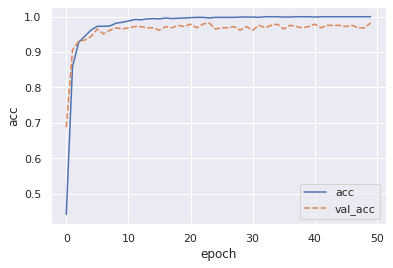

In [17]:
sns.lineplot(data=df_result[['acc', 'val_acc']])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.savefig(out.joinpath('acc_logs.pdf'))

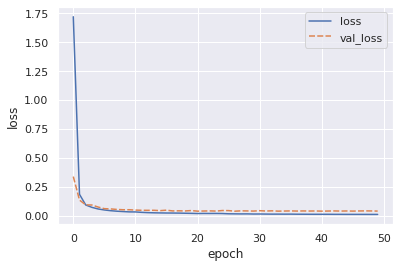

In [18]:
sns.lineplot(data=df_result[['loss', 'val_loss']])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(out.joinpath('loss_logs.pdf'))

In [19]:
dlsvm.load_weights(str(out.joinpath('model.weights.h5')))

In [20]:
dlsvm.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 8, 16)          160       
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 66,410
Trainable params: 66,410
Non-trainable params: 0
_________________________________________________________________


### Performance of model

In [21]:
df_train = pd.DataFrame(
    classification_report(y_pred=np.argmax(dlsvm.predict(X_train), axis=-1), y_true=y_train, output_dict=True)
)
print('Train perfomance of model')
print(df_train)
df_train.to_csv(out.joinpath('train-performance.csv'))

Train perfomance of model
             0.0         1.0         2.0         3.0         4.0         5.0  \
f1-score     1.0    0.987179    0.993007    0.990033    0.996283    0.992537   
precision    1.0    0.974684    1.000000    0.980263    1.000000    1.000000   
recall       1.0    1.000000    0.986111    1.000000    0.992593    0.985185   
support    145.0  154.000000  144.000000  149.000000  135.000000  135.000000   

             6.0         7.0         8.0         9.0    micro avg  \
f1-score     1.0    0.996564    0.989474    0.992857     0.993737   
precision    1.0    0.993151    1.000000    0.992857     0.993737   
recall       1.0    1.000000    0.979167    0.992857     0.993737   
support    146.0  145.000000  144.000000  140.000000  1437.000000   

             macro avg  weighted avg  
f1-score      0.993793      0.993744  
precision     0.994095      0.993853  
recall        0.993591      0.993737  
support    1437.000000   1437.000000  


In [22]:
df_test = pd.DataFrame(
    classification_report(y_pred=np.argmax(dlsvm.predict(X_test), axis=-1), y_true=y_test, output_dict=True)
)
print('Test perfomance of model')
print(df_test)
df_test.to_csv(out.joinpath('test-performance.csv'))

Test perfomance of model
                 0.0        1.0   2.0        3.0   4.0        5.0        6.0  \
f1-score    0.984615   0.982456   1.0   0.970588   1.0   0.957447   0.971429   
precision   1.000000   0.965517   1.0   0.970588   1.0   0.957447   0.971429   
recall      0.969697   1.000000   1.0   0.970588   1.0   0.957447   0.971429   
support    33.000000  28.000000  33.0  34.000000  46.0  47.000000  35.000000   

                 7.0        8.0        9.0   micro avg   macro avg  \
f1-score    0.970588   0.949153   0.987654    0.977778    0.977393   
precision   0.970588   0.965517   0.975610    0.977778    0.977670   
recall      0.970588   0.933333   1.000000    0.977778    0.977308   
support    34.000000  30.000000  40.000000  360.000000  360.000000   

           weighted avg  
f1-score       0.977727  
precision      0.977846  
recall         0.977778  
support      360.000000  


In [23]:
np.argmax(dlsvm.predict(X_train), axis=-1)

array([6, 0, 0, ..., 2, 7, 1])

In [24]:
np.argmax(dlsvm.predict(X_test), axis=-1)

array([6, 9, 3, 7, 2, 1, 5, 2, 5, 2, 1, 9, 4, 0, 4, 2, 3, 7, 8, 8, 4, 3,
       9, 7, 5, 6, 3, 5, 6, 3, 4, 9, 1, 4, 4, 6, 9, 4, 7, 6, 6, 9, 1, 3,
       6, 1, 3, 0, 6, 5, 5, 1, 9, 5, 6, 0, 9, 0, 0, 1, 7, 4, 5, 2, 4, 5,
       7, 0, 7, 5, 9, 3, 5, 4, 7, 0, 4, 5, 5, 9, 9, 0, 2, 3, 8, 0, 6, 4,
       4, 9, 1, 2, 8, 3, 5, 2, 9, 0, 4, 4, 4, 3, 5, 3, 1, 3, 5, 9, 4, 2,
       7, 7, 4, 4, 1, 9, 2, 7, 8, 7, 2, 6, 9, 4, 0, 7, 2, 7, 5, 8, 7, 5,
       7, 9, 0, 6, 6, 4, 2, 8, 0, 9, 4, 6, 9, 9, 6, 9, 0, 5, 5, 6, 6, 0,
       6, 4, 3, 9, 3, 9, 7, 2, 9, 0, 4, 5, 3, 6, 5, 9, 9, 8, 4, 2, 1, 3,
       7, 7, 2, 2, 3, 9, 8, 0, 3, 2, 2, 5, 6, 9, 9, 4, 1, 5, 4, 2, 3, 6,
       4, 8, 5, 9, 5, 7, 1, 9, 4, 8, 1, 5, 4, 4, 9, 6, 1, 8, 6, 0, 4, 5,
       2, 7, 4, 6, 4, 5, 6, 0, 3, 2, 3, 6, 7, 1, 5, 1, 4, 7, 6, 5, 8, 5,
       5, 1, 8, 2, 8, 8, 9, 9, 7, 6, 2, 2, 2, 3, 4, 8, 8, 3, 6, 0, 9, 7,
       7, 0, 1, 0, 4, 5, 1, 5, 3, 6, 0, 4, 1, 0, 0, 3, 6, 5, 9, 7, 3, 5,
       5, 9, 9, 8, 5, 3, 3, 2, 0, 5, 8, 3, 4, 0, 2,